This script is to map the fire data w weather data
- Input Data: 
    - "../New_Data/calfire_fod_fpa_2001_2020_copy.xlsx"
    - Raw Weather data to get weather grid: ../Weather_Data/dead_fuel_moisture_1000hr.2001.2023.CA.nc
- Output Dara: 
    - "../Clean_Data/Fire_Data/calfire_fod_fpa_2001_2020_dedup.parquet"
    - "../Clean_Data/Fire_Data/calfire_fod_fpa_2001_2020_dedup_map_weather_grid.parquet"

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
from scipy.spatial import cKDTree

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [5]:
# example to use geodesic()
from geopy.distance import geodesic

# Define the coordinates
coords_1 = (40.452058, -124.374975)
coords_2 = (40.41039, -124.374975)

# Calculate the distance
distance = geodesic(coords_1, coords_2).km

# Print the distance
print(f"Distance: {distance} km")

Distance: 4.626936837923472 km


## Generate Summary Data

In [6]:
calfire_dat = pd.read_excel('../New_Data/calfire_fod_fpa_2001_2020_copy.xlsx')  

In [7]:
calfire_dat.shape

(176939, 38)

In [8]:
# fill missing value in CONT_DATE with the value "missing date"
# this is for groyupby operation later
calfire_dat['CONT_DATE'] = calfire_dat['CONT_DATE'].fillna('missing date')

In [9]:
# check missing rate in column CONT_DATE
missing_rate = calfire_dat['CONT_DATE'].isnull().sum()/calfire_dat.shape[0]
print(f"Missing rate in column CONT_DATE: {missing_rate}")

Missing rate in column CONT_DATE: 0.0


In [13]:
calfire_dat['NWCG_CAUSE_CLASSIFICATION'].value_counts()

NWCG_CAUSE_CLASSIFICATION
Human                                      120007
Missing data/not specified/undetermined     38147
Natural                                     18785
Name: count, dtype: int64

In [14]:
# check missing rate in column NWCG_CAUSE_CLASSIFICATION
missing_rate = calfire_dat['NWCG_CAUSE_CLASSIFICATION'].isnull().sum()/calfire_dat.shape[0]
print(f"Missing rate in column NWCG_CAUSE_CLASSIFICATION: {missing_rate}")

Missing rate in column NWCG_CAUSE_CLASSIFICATION: 0.0


In [16]:
summary_fire = calfire_dat.groupby(['LONGITUDE', 'LATITUDE', 'DISCOVERY_DATE', 'CONT_DATE']).agg(
    max_FIRE_SIZE=('FIRE_SIZE', 'max'),
    min_FIRE_SIZE=('FIRE_SIZE', 'min'),
    # count # of rows
    FOD_ID_cnt=('FOD_ID', 'count'),
    NWCG_CAUSE_CLASSIFICATION=('NWCG_CAUSE_CLASSIFICATION', lambda x: list(set(x)))
).sort_values('FOD_ID_cnt', ascending=False)

summary_fire = summary_fire.reset_index()

# calculate diff between max_FIRE_SIZE and min_FIRE_SIZE
summary_fire['diff_FIRE_SIZE'] = summary_fire['max_FIRE_SIZE'] - summary_fire['min_FIRE_SIZE']

In [17]:
summary_fire.shape

(175257, 9)

In [18]:
summary_fire.head()

,LONGITUDE,LATITUDE,DISCOVERY_DATE,CONT_DATE,max_FIRE_SIZE,min_FIRE_SIZE,FOD_ID_cnt,NWCG_CAUSE_CLASSIFICATION,diff_FIRE_SIZE
0,-123.943617,40.476117,10/28/2015,10/28/2015,0.01,0.01,18,[Human],0.0
1,-120.850714,38.641597,7/16/2006,7/17/2006,13.80,0.10,14,[Human],13.7
2,-121.607969,39.806769,11/28/2003,11/28/2003,0.10,0.10,11,[Human],0.0
3,-123.163889,39.678056,10/28/2005,10/28/2005,0.10,0.10,11,[Human],0.0
4,-120.710000,38.293056,5/17/2007,missing date,7.00,1.00,9,[Human],6.0


In [19]:
summary_fire['NWCG_CAUSE_CLASSIFICATION'].value_counts()

NWCG_CAUSE_CLASSIFICATION
[Human]                                               118638
[Missing data/not specified/undetermined]              37841
[Natural]                                              18668
[Human, Missing data/not specified/undetermined]          95
[Human, Natural]                                          14
[Missing data/not specified/undetermined, Natural]         1
Name: count, dtype: int64

In [20]:
# save summary_fire to parquet file
summary_fire.to_parquet('../Clean_Data/Fire_Data/calfire_fod_fpa_2001_2020_dedup.parquet')

## Analysis (can skip)

In [ ]:
# only keep rows that have FOD_ID_cnt > 1
summary_fire = summary_fire[summary_fire['FOD_ID_cnt'] > 1]

In [147]:
summary_fire.shape

(1262, 8)

In [146]:
summary_fire.head()

,LONGITUDE,LATITUDE,DISCOVERY_DATE,CONT_DATE,max_FIRE_SIZE,min_FIRE_SIZE,FOD_ID_cnt,diff_FIRE_SIZE
0,-123.943617,40.476117,10/28/2015,10/28/2015,0.01,0.01,18,0.0
1,-120.850714,38.641597,7/16/2006,7/17/2006,13.80,0.10,14,13.7
2,-121.607969,39.806769,11/28/2003,11/28/2003,0.10,0.10,11,0.0
3,-123.163889,39.678056,10/28/2005,10/28/2005,0.10,0.10,11,0.0
4,-120.710000,38.293056,5/17/2007,missing date,7.00,1.00,9,6.0


In [175]:
# write to csv file
summary_fire.to_csv('../Summary_Data/Summary_Repeated_Record.csv')

In [153]:
summary_fire_same_size = summary_fire[summary_fire['max_FIRE_SIZE'] == summary_fire['min_FIRE_SIZE']]
# only keep first 4 columns
summary_fire_same_size = summary_fire_same_size.reset_index().iloc[:, :5]
# add column repeatID using index of summary_fire_same_size
summary_fire_same_size['repeatID'] = summary_fire_same_size.index
# drop column FOD_ID_cnt
summary_fire_same_size = summary_fire_same_size.drop(columns='index')

calfire_dat_repeat_record_same_fire_infor = calfire_dat.merge(summary_fire_same_size, how='inner', on=['LONGITUDE', 'LATITUDE', 'DISCOVERY_DATE', 'CONT_DATE'])
calfire_dat_repeat_record_same_fire_infor.to_csv('../Summary_Data/FOD_FPA_fire_repeat_record_same_location_date_size.csv', index=False)

In [ ]:
summary_fire_diff_size = summary_fire[summary_fire['max_FIRE_SIZE'] != summary_fire['min_FIRE_SIZE']]
# only keep first 4 columns
summary_fire_diff_size = summary_fire_diff_size.reset_index().iloc[:, :5]
# add column repeatID using index of summary_fire_same_size
summary_fire_diff_size['repeatID'] = summary_fire_diff_size.index
summary_fire_diff_size = summary_fire_diff_size.drop(columns='index')

calfire_dat_repeat_record_same_fire_infor_v2 = calfire_dat.merge(summary_fire_diff_size, how='inner', on=['LONGITUDE', 'LATITUDE', 'DISCOVERY_DATE', 'CONT_DATE'])
calfire_dat_repeat_record_same_fire_infor_v2.to_csv('../Summary_Data/FOD_FPA_fire_repeat_record_same_location_date_diff_size.csv', index=False)

## Old code on checking data

In [63]:
# check if there is any duplicated rows
calfire_dat.duplicated().sum()

0

In [137]:
# check if FOD_ID is unique
calfire_dat['FOD_ID'].nunique() == calfire_dat.shape[0]

True

In [65]:
calfire_dat['FPA_ID'].nunique() == calfire_dat.shape[0]

True

In [18]:
# check missing rate for each column
calfire_dat.isnull().mean()

OBJECTID                         0.000000
FOD_ID                           0.000000
FPA_ID                           0.000000
SOURCE_SYSTEM_TYPE               0.000000
SOURCE_SYSTEM                    0.000000
NWCG_REPORTING_AGENCY            0.000000
NWCG_REPORTING_UNIT_ID           0.000000
NWCG_REPORTING_UNIT_NAME         0.000000
SOURCE_REPORTING_UNIT            0.000000
SOURCE_REPORTING_UNIT_NAME       0.000000
LOCAL_FIRE_REPORT_ID             0.740899
LOCAL_INCIDENT_ID                0.192151
FIRE_CODE                        0.707521
FIRE_NAME                        0.246554
ICS_209_PLUS_INCIDENT_JOIN_ID    0.980779
ICS_209_PLUS_COMPLEX_JOIN_ID     0.994032
MTBS_ID                          0.994032
MTBS_FIRE_NAME                   0.994032
COMPLEX_NAME                     0.993636
FIRE_YEAR                        0.000000
DISCOVERY_DATE                   0.000000
DISCOVERY_DOY                    0.000000
DISCOVERY_TIME                   0.021341
NWCG_CAUSE_CLASSIFICATION        0

In [66]:
pd.set_option('display.max_colwidth', None)

### Examples on duplicate records

In [67]:
# print row 46600 and 46601
calfire_dat.iloc[46600:46602]

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME
46600,46601,1331238,SFO-2001CACDFHUU003329,NONFED,ST-CACDF,ST/C&L,USCAHUU,Humboldt-Del Norte Unit,CAHUU,Humboldt-Del Norte Unit,...,1954.0,0.1,A,40.598889,-124.246111,MISSING/NOT SPECIFIED,CA,HUMBOLDT,6023.0,Humboldt County
46601,46602,1331239,SFO-2001CACDFHUU003330,NONFED,ST-CACDF,ST/C&L,USCAHUU,Humboldt-Del Norte Unit,CAHUU,Humboldt-Del Norte Unit,...,1954.0,0.1,A,40.598889,-124.246111,MISSING/NOT SPECIFIED,CA,HUMBOLDT,6023.0,Humboldt County


In [68]:
calfire_dat.iloc[46600:46602].T[calfire_dat.iloc[46600] != calfire_dat.iloc[46601]]

,46600,46601
OBJECTID,46601,46602
FOD_ID,1331238,1331239
FPA_ID,SFO-2001CACDFHUU003329,SFO-2001CACDFHUU003330
LOCAL_FIRE_REPORT_ID,NaN,NaN
LOCAL_INCIDENT_ID,003329,003330
FIRE_CODE,NaN,NaN
FIRE_NAME,PHELAN 1,PHELAN 2
ICS_209_PLUS_INCIDENT_JOIN_ID,NaN,NaN
ICS_209_PLUS_COMPLEX_JOIN_ID,NaN,NaN
MTBS_ID,NaN,NaN


## Mapping after dedup

In [21]:
# read summary parquet file
summary_fire = pd.read_parquet('../Clean_Data/Fire_Data/calfire_fod_fpa_2001_2020_dedup.parquet')

In [22]:
summary_fire.shape

(175257, 9)

In [23]:
summary_fire.head()

,LONGITUDE,LATITUDE,DISCOVERY_DATE,CONT_DATE,max_FIRE_SIZE,min_FIRE_SIZE,FOD_ID_cnt,NWCG_CAUSE_CLASSIFICATION,diff_FIRE_SIZE
0,-123.943617,40.476117,10/28/2015,10/28/2015,0.01,0.01,18,[Human],0.0
1,-120.850714,38.641597,7/16/2006,7/17/2006,13.80,0.10,14,[Human],13.7
2,-121.607969,39.806769,11/28/2003,11/28/2003,0.10,0.10,11,[Human],0.0
3,-123.163889,39.678056,10/28/2005,10/28/2005,0.10,0.10,11,[Human],0.0
4,-120.710000,38.293056,5/17/2007,missing date,7.00,1.00,9,[Human],6.0


In [24]:
files = os.listdir('../Weather_Data/')
data_dir = '../Weather_Data/'
# Load the first dataset to use as a reference
reference_ds = xr.open_dataset(os.path.join(data_dir, files[0]))

# Extract lon and lat coordinates
lon = reference_ds.coords['lon'].values
lat = reference_ds.coords['lat'].values

# Create a DataFrame with all combinations of lon and lat
lon_lat_combinations = pd.DataFrame([(lo, la) for lo in lon for la in lat], columns=['lon', 'lat'])
lon_lat_combinations.shape

(62160, 2)

In [26]:
# Create a KDTree for the reference coordinates
tree = cKDTree(lon_lat_combinations[['lat', 'lon']].values)

# Query the nearest neighbors for each point in calfire_dat
approx_distances, indices = tree.query(summary_fire[['LATITUDE', 'LONGITUDE']].values, k=1)

In [27]:
# Calculate the exact geodesic distances
exact_distances = []
nearest_lats = []
nearest_lons = []

for i, idx in enumerate(indices):
    coords_1 = (summary_fire.iloc[i]['LATITUDE'], summary_fire.iloc[i]['LONGITUDE'])
    coords_2 = (lon_lat_combinations.iloc[idx]['lat'], lon_lat_combinations.iloc[idx]['lon'])
    distance = geodesic(coords_1, coords_2).km
    exact_distances.append(distance)
    nearest_lats.append(coords_2[0])
    nearest_lons.append(coords_2[1])

# Convert exact_distances to a numpy array
exact_distances = np.array(exact_distances)

# Add the nearest lat, lon, and distance to summary_fire
summary_fire['NEAREST_LAT'] = nearest_lats
summary_fire['NEAREST_LON'] = nearest_lons
summary_fire['DISTANCE_KM'] = exact_distances

In [28]:
summary_fire.shape

(175257, 12)

In [29]:
exact_distances.min(), exact_distances.max()

(2.4990948926365377e-06, 3.012844457014936)

In [30]:
summary_fire.to_parquet('../Clean_Data/Fire_Data/calfire_fod_fpa_2001_2020_dedup_map_weather_grid.parquet')

## Mapping before dedup

(there is typo, do not use the results)

In [72]:
columns_to_drop = ['OBJECTID','FOD_ID', 'FPA_ID', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 
                   'FIRE_CODE', 'FIRE_NAME','ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID']
# drop columns
calfire_dat = calfire_dat.drop(columns=columns_to_drop)

In [73]:
# check if duplicated rows
calfire_dat.duplicated().sum()

293

In [75]:
# print # of rows now in a sentence
print(f'The dataset has {calfire_dat.shape[0]} rows.')
calfire_dat = calfire_dat.drop_duplicates()
# print # of rows now in a sentence
print(f'After dedup, the dataset has {calfire_dat.shape[0]} rows.')

The dataset has 176939 rows.
After dedup, the dataset has 176646 rows.


In [94]:
# reset index
calfire_dat = calfire_dat.reset_index(drop=True)

In [80]:
# check sample rows of DISCOVERY_DATE and CONT_DATE
calfire_dat[['DISCOVERY_DATE', 'CONT_DATE']].head(5)

,DISCOVERY_DATE,CONT_DATE
0,2/2/2005,2/2/2005
1,5/12/2004,5/12/2004
2,5/31/2004,5/31/2004
3,6/28/2004,7/3/2004
4,6/28/2004,7/3/2004


In [81]:
# convert the date columns to datetime format
calfire_dat['DISCOVERY_DATE'] = pd.to_datetime(calfire_dat['DISCOVERY_DATE'], format='%m/%d/%Y')
calfire_dat['CONT_DATE'] = pd.to_datetime(calfire_dat['CONT_DATE'], format='%m/%d/%Y')

In [82]:
calfire_dat[['DISCOVERY_DATE', 'CONT_DATE']].head(5)

,DISCOVERY_DATE,CONT_DATE
0,2005-02-02,2005-02-02
1,2004-05-12,2004-05-12
2,2004-05-31,2004-05-31
3,2004-06-28,2004-07-03
4,2004-06-28,2004-07-03


In [83]:
# check if CONT_DATE is always later than DISCOVERY_DATE
(calfire_dat['CONT_DATE'] - calfire_dat['DISCOVERY_DATE']).dt.days.min()

0.0

In [84]:
files = os.listdir('../Weather_Data/')
files

['dead_fuel_moisture_1000hr.2001.2023.CA.nc',
 'dead_fuel_moisture_100hr.2001.2023.CA.nc',
 'expanded_Palmer_Drought_Severity_Index.2001.2023.CA.nc',
 'max_air_temperature.2001.2023.CA-008.nc',
 'max_relative_humidity.2001.2023.CA.nc',
 'max_wind_speed.2001.2023.CA.nc',
 'min_air_temperature.2001.2023.CA-009.nc',
 'min_relative_humidity.2001.2023.CA.nc',
 'Palmer_Drought_Severity_Index.2001.2023.CA.nc',
 'precipitation_amount.2001.2023.CA.nc',
 'specific_humidity.2001.2023.CA.nc',
 'surface_downwelling_shortwave_flux.2001.2023.CA.nc',
 'wind_from_direction.2001.2023.CA.nc',
 'wind_speed.2001.2023.CA.nc']

In [85]:
data_dir = '../Weather_Data/'
# Load the first dataset to use as a reference
reference_ds = xr.open_dataset(os.path.join(data_dir, files[0]))

In [27]:
print(f"Dimensions: {reference_ds.dims}")
print(f"Coordinates: {reference_ds.coords}")
print(f"Data variables: {reference_ds.data_vars}")

Dimensions: Frozen({'day': 8400, 'lon': 259, 'lat': 240})
Coordinates: Coordinates:
  * day      (day) datetime64[ns] 2001-01-01 2001-01-02 ... 2023-12-31
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -114.1 -114.1 -114.0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.15 32.11 32.07 32.03
Data variables: Data variables:
    dead_fuel_moisture_1000hr  (day, lat, lon) float32 ...


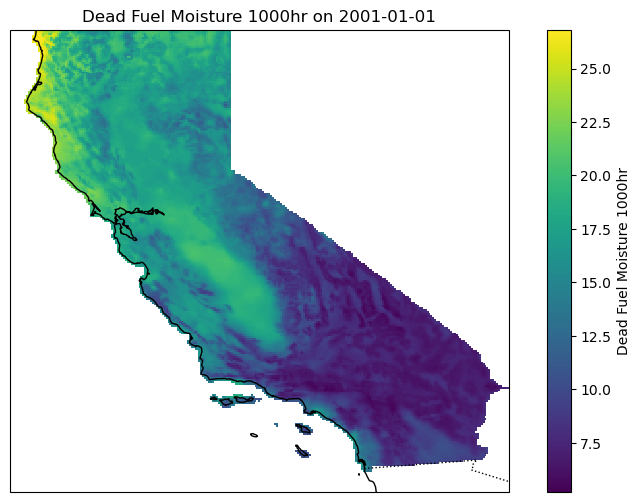

In [28]:
# check how sample data looks like in map

# extract data when day = "2001-01-01"
dead_fuel_2001 = reference_ds.sel(day="2001-01-01")

# Plot the data variable on a map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([dead_fuel_2001.lon.min(), dead_fuel_2001.lon.max(), dead_fuel_2001.lat.min(), dead_fuel_2001.lat.max()], crs=ccrs.PlateCarree())

# Add coastlines and borders for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the data variable
data = dead_fuel_2001['dead_fuel_moisture_1000hr']
data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Dead Fuel Moisture 1000hr'})

# Add a title
plt.title('Dead Fuel Moisture 1000hr on 2001-01-01')

# Show the plot
plt.show()

In [86]:
# Extract lon and lat coordinates
lon = reference_ds.coords['lon'].values
lat = reference_ds.coords['lat'].values

# Create a DataFrame with all combinations of lon and lat
lon_lat_combinations = pd.DataFrame([(lo, la) for lo in lon for la in lat], columns=['lon', 'lat'])

In [87]:
lon_lat_combinations.shape

(62160, 2)

In [88]:
# check if there is any duplicated rows
lon_lat_combinations.duplicated().sum()

0

In [89]:
from scipy.spatial import cKDTree

# Create a KDTree for the reference coordinates
tree = cKDTree(lon_lat_combinations[['lat', 'lon']].values)

# Query the nearest neighbors for each point in calfire_dat
approx_distances, indices = tree.query(calfire_dat[['LATITUDE', 'LONGITUDE']].values, k=1)

In [90]:
# Calculate the exact geodesic distances
exact_distances = []
nearest_lats = []
nearest_lons = []

for i, idx in enumerate(indices):
    coords_1 = (calfire_dat.iloc[i]['LATITUDE'], calfire_dat.iloc[i]['LONGITUDE'])
    coords_2 = (lon_lat_combinations.iloc[idx]['lat'], lon_lat_combinations.iloc[idx]['lon'])
    distance = geodesic(coords_1, coords_2).km
    exact_distances.append(distance)
    nearest_lats.append(coords_1[0])
    nearest_lons.append(coords_1[1])

# Convert exact_distances to a numpy array
exact_distances = np.array(exact_distances)

# Add the nearest lat, lon, and distance to calfire_dat
calfire_dat['NEAREST_LAT'] = nearest_lats
calfire_dat['NEAREST_LON'] = nearest_lons
calfire_dat['DISTANCE_KM'] = exact_distances

In [91]:
calfire_dat.shape # 176,646

(176646, 33)

In [92]:
#  check the range pf distances
exact_distances.min(), exact_distances.max()

(2.4990948926365377e-06, 3.012844457014936)

In [44]:
import seaborn as sns

In [50]:
color_map = {
    'A': 'blue',
    'B': 'green',
    'C': 'orange',
    'D': 'red',
    'E': 'purple',
    'F': 'brown',
    'G': 'pink'
}
colors = calfire_dat['FIRE_SIZE_CLASS'].map(color_map)

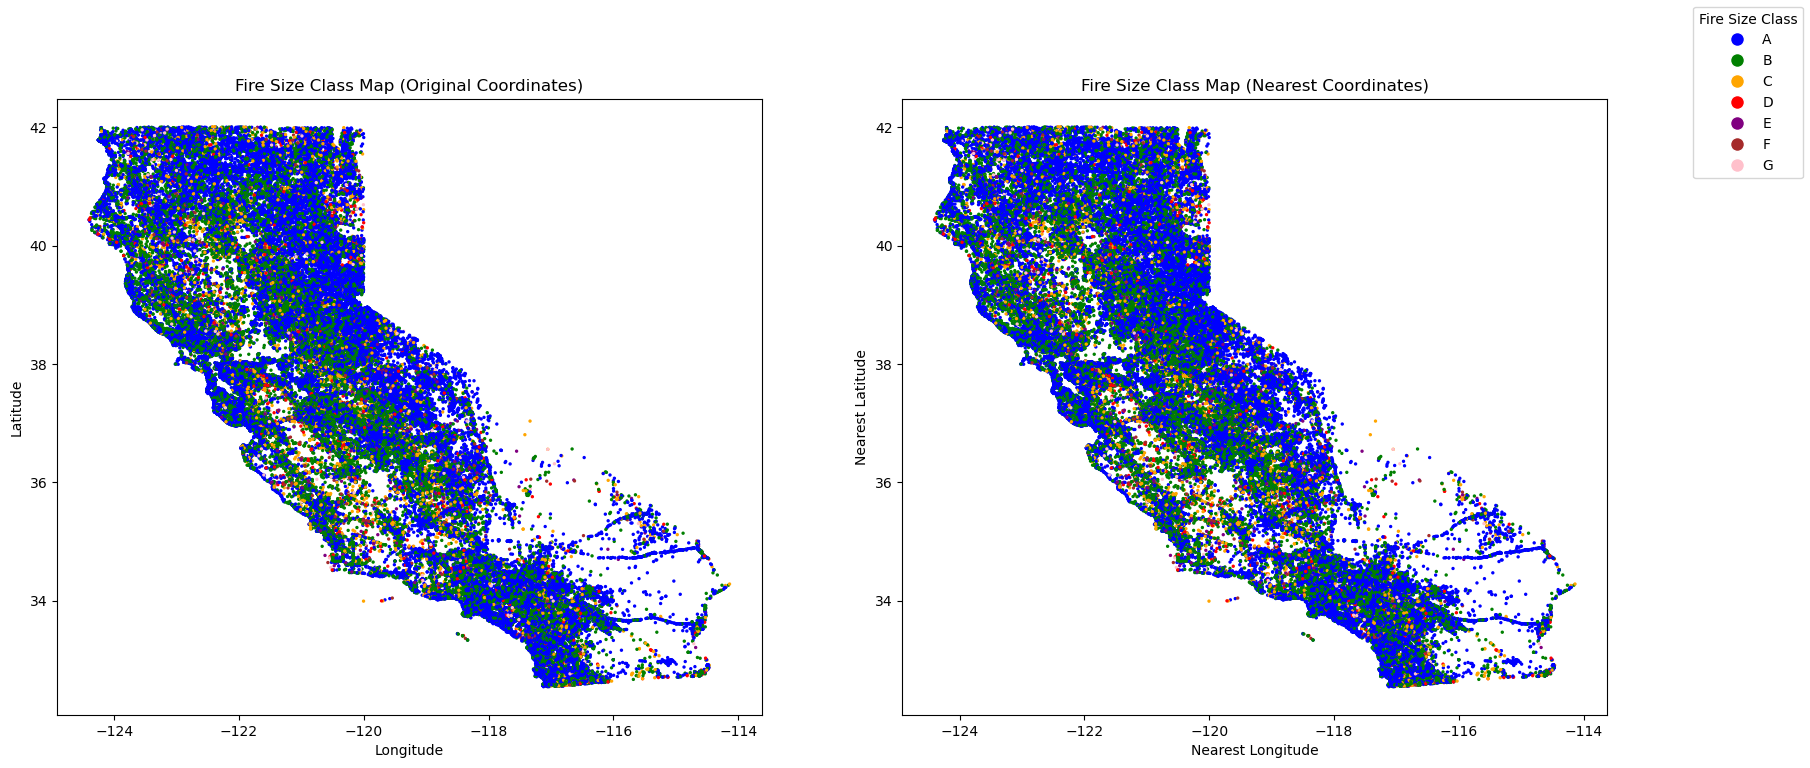

In [52]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the first scatter plot
axes[0].scatter(calfire_dat['LONGITUDE'], calfire_dat['LATITUDE'], c=colors, s=2)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Fire Size Class Map (Original Coordinates)')

# Plot the second scatter plot
axes[1].scatter(calfire_dat['NEAREST_LON'], calfire_dat['NEAREST_LAT'], c=colors, s=2)
axes[1].set_xlabel('Nearest Longitude')
axes[1].set_ylabel('Nearest Latitude')
axes[1].set_title('Fire Size Class Map (Nearest Coordinates)')

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=cls)
           for cls, color in color_map.items()]
fig.legend(handles=handles, title='Fire Size Class', loc='upper right')

plt.show()

In [93]:
# drop column geometry and centroid for saving data in parquet format
calfire_dat.to_parquet('../Clean_Data/Fire_Data/calfire_fod_fpa_2001_2020_map_weather_grid.parquet')